In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms, models, models
from torch.utils.data import DataLoader, ConcatDataset, Subset, Dataset
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import os
import requests
from io import BytesIO
from PIL import Image
import random
from pathlib import Path

In [1]:
!git clone https://github.com/MajidrNEO1879/arithmetic-detection.git

Cloning into 'arithmetic-detection'...
remote: Enumerating objects: 10088, done.
remote: Counting objects: 100% (10088/10088), done.
remote: Compressing objects: 100% (9260/9260), done.
remote: Total 10088 (delta 843), reused 10070 (delta 827), pack-reused 0 (from 0)
Receiving objects: 100% (10088/10088), 59.02 MiB | 29.76 MiB/s, done.
Resolving deltas: 100% (843/843), done.


In [122]:
def display_random_images(directory_path):
    """
    Display random images from a directory in a 2x3 grid with class names
    
    Args:
        directory_path (str): Path to the directory containing images
    """
    # Get all image files from the directory and their classes
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    
    # Dictionary to store images by class
    images_by_class = {}
    
    # Walk through directory structure (handles nested class folders)
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                # Get class name (folder name)
                class_name = os.path.basename(root)
                if class_name not in images_by_class:
                    images_by_class[class_name] = []
                images_by_class[class_name].append(os.path.join(root, file))
    
    # If no nested structure, treat all images as one class
    if not images_by_class:
        image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                      if f.lower().endswith(image_extensions)]
        if image_files:
            images_by_class['all_images'] = image_files
    
    if not images_by_class:
        print("No images found in the directory!")
        return
    
    # Flatten all images and select 6 random ones
    all_images = []
    for class_name, img_list in images_by_class.items():
        for img_path in img_list:
            all_images.append((img_path, class_name))
    
    if len(all_images) < 6:
        print(f"Warning: Only {len(all_images)} images found, but 6 are needed for 2x3 grid")
    
    selected_images = random.sample(all_images, min(6, len(all_images)))
    
    # Create 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(8, 8))
    fig.suptitle(f'Random Images from Directory', fontsize=16)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, (ax, (img_path, class_name)) in enumerate(zip(axes, selected_images)):
        try:
            # Load and display image
            img = Image.open(img_path)
            
            ax.imshow(img)
            ax.set_title(f'Class: {class_name}\n{os.path.basename(img_path)}\n{img.size[0]}x{img.size[1]}', 
                        fontsize=10)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{os.path.basename(img_path)}\nClass: {class_name}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.axis('off')
            print(f"Error loading {img_path}: {e}")
    
    # Hide any unused subplots
    for i in range(len(selected_images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [100]:
resnet34_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(num_output_channels=3),
    
    # Important augmentations for handwriting
    transforms.RandomRotation(degrees=15),  # Small rotations (people write at angles)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Slight position shifts
        scale=(0.9, 1.1),      # Slight size variations
        shear=10               # Slant variations (italic-like)
    ),
    
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
    # Optional: Add slight elastic distortion-like effect via random erasing
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Testing convex models

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# def display_random_mnist_images(dataset, num_rows=2, num_cols=3):
#     """
#     Display random images from a PyTorch MNIST dataset in a grid
    
#     Args:
#         dataset: PyTorch dataset (e.g., MNIST)
#         num_rows: Number of rows in the grid
#         num_cols: Number of columns in the grid
#     """
#     num_images = num_rows * num_cols
    
#     # Create subplots
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    
#     # If only one row/column, make axes iterable
#     if num_rows == 1 and num_cols == 1:
#         axes = [axes]
#     elif num_rows == 1 or num_cols == 1:
#         axes = axes.flatten()
    
#     # Select random indices
#     indices = random.sample(range(len(dataset)), num_images)
    
#     for i, (ax, idx) in enumerate(zip(axes.flatten(), indices)):
#         # Get image and label
#         image, label = dataset[idx]
        
#         # For MNIST with transforms, image might be normalized
#         # Denormalize if needed (assuming ImageNet normalization was applied)
#         if image.shape[0] == 3:  # RGB image
#             # Denormalize
#             mean = [0.485, 0.456, 0.406]
#             std = [0.229, 0.224, 0.225]
#             image_denorm = image.clone()
#             for j in range(3):
#                 image_denorm[j] = image[j] * std[j] + mean[j]
#             image_display = image_denorm
#         else:  # Grayscale
#             image_display = image
        
#         # Convert tensor to numpy for plotting
#         image_np = image_display.numpy().transpose(1, 2, 0)
        
#         # Plot
#         ax.imshow(image_np, cmap='gray' if image_np.shape[2] == 1 else None)
#         ax.set_title(f'Label: {label}\nIndex: {idx}')
#         ax.axis('off')
    
#     plt.tight_layout()
#     plt.show()

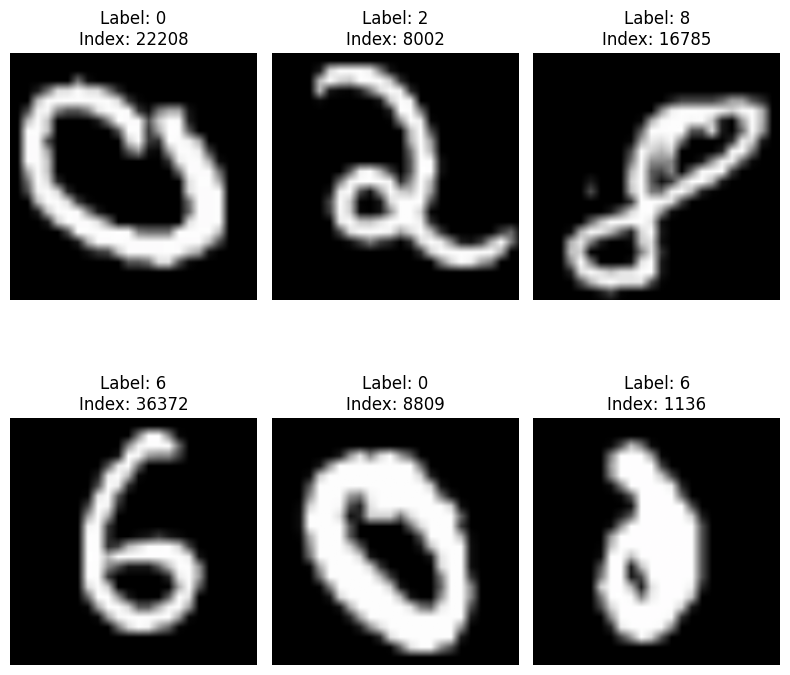

In [9]:
# display_random_mnist_images(mnist_train, 2, 3)

In [6]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir('/kaggle/working/arithmetic-detection/cleaned_handwritten_data')

There are 2 directories and 0 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data'.
There are 19 directories and 0 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test'.
There are 0 directories and 111 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/8'.
There are 0 directories and 116 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/mul'.
There are 0 directories and 80 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/y'.
There are 0 directories and 125 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/dec'.
There are 0 directories and 106 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/4'.
There are 0 directories and 124 images in '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/div'.
There are 0 directories and 120 images in '/kaggle/working/arithmetic-detection/cleaned_handwri

displaying random images from cutom dataset

In [14]:
def display_random_images(directory_path):
    """
    Display random images from a directory in a 2x3 grid with class names
    
    Args:
        directory_path (str): Path to the directory containing images
    """
    # Get all image files from the directory and their classes
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    
    # Dictionary to store images by class
    images_by_class = {}
    
    # Walk through directory structure (handles nested class folders)
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                # Get class name (folder name)
                class_name = os.path.basename(root)
                if class_name not in images_by_class:
                    images_by_class[class_name] = []
                images_by_class[class_name].append(os.path.join(root, file))
    
    # If no nested structure, treat all images as one class
    if not images_by_class:
        image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                      if f.lower().endswith(image_extensions)]
        if image_files:
            images_by_class['all_images'] = image_files
    
    if not images_by_class:
        print("No images found in the directory!")
        return
    
    # Flatten all images and select 6 random ones
    all_images = []
    for class_name, img_list in images_by_class.items():
        for img_path in img_list:
            all_images.append((img_path, class_name))
    
    if len(all_images) < 6:
        print(f"Warning: Only {len(all_images)} images found, but 6 are needed for 2x3 grid")
    
    selected_images = random.sample(all_images, min(6, len(all_images)))
    
    # Create 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(8, 8))
    fig.suptitle(f'Random Images from Directory', fontsize=16)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, (ax, (img_path, class_name)) in enumerate(zip(axes, selected_images)):
        try:
            # Load and display image
            img = Image.open(img_path)
            
            ax.imshow(img)
            ax.set_title(f'Class: {class_name}\n{os.path.basename(img_path)}\n{img.size[0]}x{img.size[1]}', 
                        fontsize=10)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{os.path.basename(img_path)}\nClass: {class_name}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.axis('off')
            print(f"Error loading {img_path}: {e}")
    
    # Hide any unused subplots
    for i in range(len(selected_images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

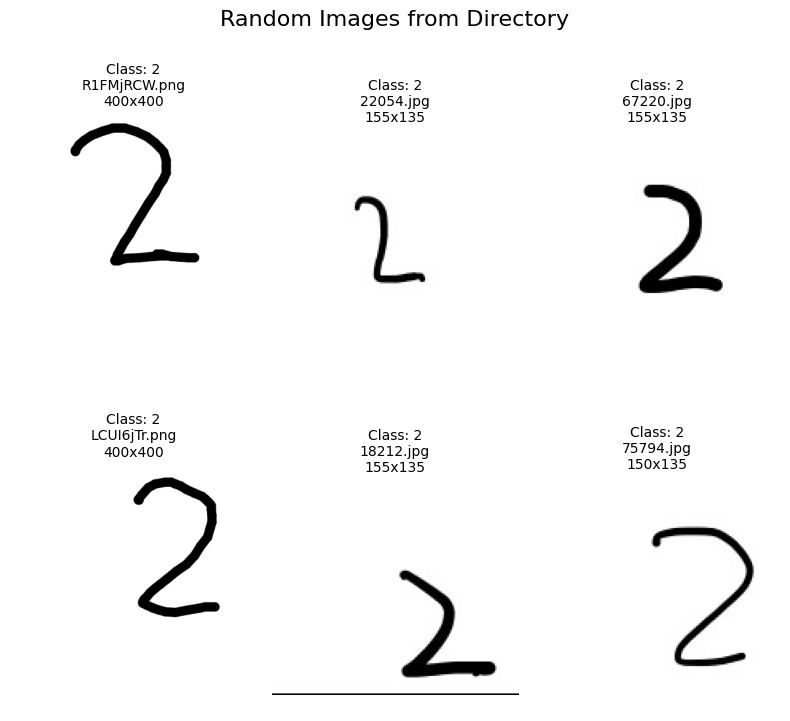

In [15]:
display_random_images('/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test/2')

In [14]:
# class OffsetImageFolder(datasets.ImageFolder):
#     def __init__(self, root, transform=None, class_offset=0, target_offset=0):
#         super().__init__(root, transform=transform)
#         self.class_offset = class_offset
#         self.target_offset = target_offset

#         # Optionally offset class names (display purposes only)
#         if self.class_offset != 0:
#             self.original_classes = self.classes
#             self.classes = [f"{i + self.class_offset} - {cls}" for i, cls in enumerate(self.original_classes)]
#         else:
#             self.original_classes = self.classes

#         # Apply target offset for training
#         if self.target_offset != 0:
#             self.targets = [t + self.target_offset for t in self.targets]
#             self.samples = [(path, t + self.target_offset) for path, t in self.samples]

#     def __getitem__(self, index):
#         image, label = super().__getitem__(index)
#         # Convert label to tensor to avoid DataLoader issues
#         label = torch.tensor(label, dtype=torch.long)
#         return image, label

#     def get_original_classes(self):
#         return self.original_classes

In [15]:
# class SubsetWithTensorTargets(Subset):
#     def __getitem__(self, idx):
#         image, label = super().__getitem__(idx)
#         label = torch.tensor(label, dtype=torch.long)
#         return image, label

# def balanced_mnist_subset(dataset, n_per_class):
#     targets = np.array(dataset.targets)
#     indices = []

#     for class_label in np.unique(targets):
#         class_indices = np.where(targets == class_label)[0]
#         chosen = np.random.choice(class_indices, n_per_class, replace=False)
#         indices.extend(chosen)

#     # Pass dataset and indices separately to SubsetWithTensorTargets
#     return SubsetWithTensorTargets(dataset, indices)



In [16]:
# mnist_train_balanced = balanced_mnist_subset(mnist_train, n_per_class=550)
# mnist_test_balanced  = balanced_mnist_subset(mnist_test, n_per_class=150)

In [17]:
def inspect_folder_spaces(directory):
    """Show all folders and highlight those with trailing spaces"""
    print(f"All folders in: {directory}")
    print("-" * 40)
    
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            if item.endswith(' '):
                print(f"⚠️  '{item}' ← HAS TRAILING SPACE!")
            else:
                print(f"  '{item}'")


# Usage
inspect_folder_spaces("/kaggle/working/arithmetic-detection/cleaned_handwritten_data")

All folders in: /kaggle/working/arithmetic-detection/cleaned_handwritten_data
----------------------------------------
  'test'
  'train'


In [19]:
# custom_train_ops = OffsetImageFolder(
#     root="./arithmetic-detection/cleaned_symbols/train",
#     transform=resnet34_transformer,
#     class_offset=0,
#     target_offset = 10
# )
# custom_test_ops = OffsetImageFolder(
#     root="./arithmetic-detection/cleaned_symbols/val",
#     transform=resnet34_transformer,
#     class_offset=0,
#     target_offset = 10
# )

In [18]:
train_dir = '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/train'
test_dir = '/kaggle/working/arithmetic-detection/cleaned_handwritten_data/test'

In [103]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=resnet34_transformer, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=resnet34_transformer)


In [24]:
all_labels = []

for _, label in train_data:
    all_labels.append(label)

# Get number of unique classes
num_classes = len(torch.unique(torch.tensor(all_labels)))
print("Number of unique classes:", num_classes)

Number of unique classes: 19


In [104]:
train_loader = DataLoader(train_data, batch_size=32, shuffle= True)
test_loader = DataLoader(test_data, batch_size=32, shuffle= False)

In [31]:
# for images, labels in test_loader:
#     print(labels)

In [32]:
# weights = torchvision.models.ResNet34_Weights.DEFAULT # .DEFAULT = best available weights 
# model = torchvision.models.resnet34(weights=weights).to(device)

In [105]:
weights = models.ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights).to(device)

In [106]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [107]:
for param in model.parameters():
    param.requires_grad = False

In [108]:
num_classes = 19
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

In [109]:
# num_classes = 14
# model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# # Move to device AFTER modifying
# model = model.to(device)

In [110]:
summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 19]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [111]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

In [113]:
results = train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2379 | train_acc: 0.6594 | test_loss: 0.5829 | test_acc: 0.8139
Epoch: 2 | train_loss: 0.7003 | train_acc: 0.7904 | test_loss: 0.5463 | test_acc: 0.8329
Epoch: 3 | train_loss: 0.6669 | train_acc: 0.8095 | test_loss: 0.6290 | test_acc: 0.8264
Epoch: 4 | train_loss: 0.6517 | train_acc: 0.8177 | test_loss: 0.5531 | test_acc: 0.8413
Epoch: 5 | train_loss: 0.6984 | train_acc: 0.8197 | test_loss: 0.5039 | test_acc: 0.8659


In [114]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

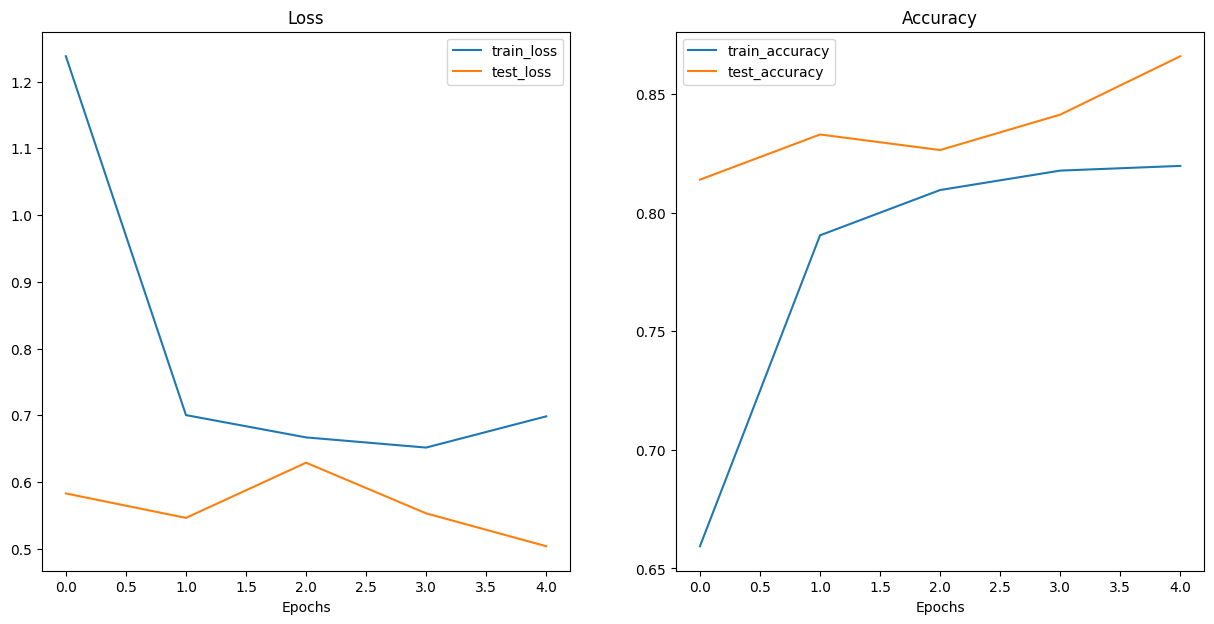

In [115]:
plot_loss_curves(results)

In [116]:
combined_classes = train_data.classes

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


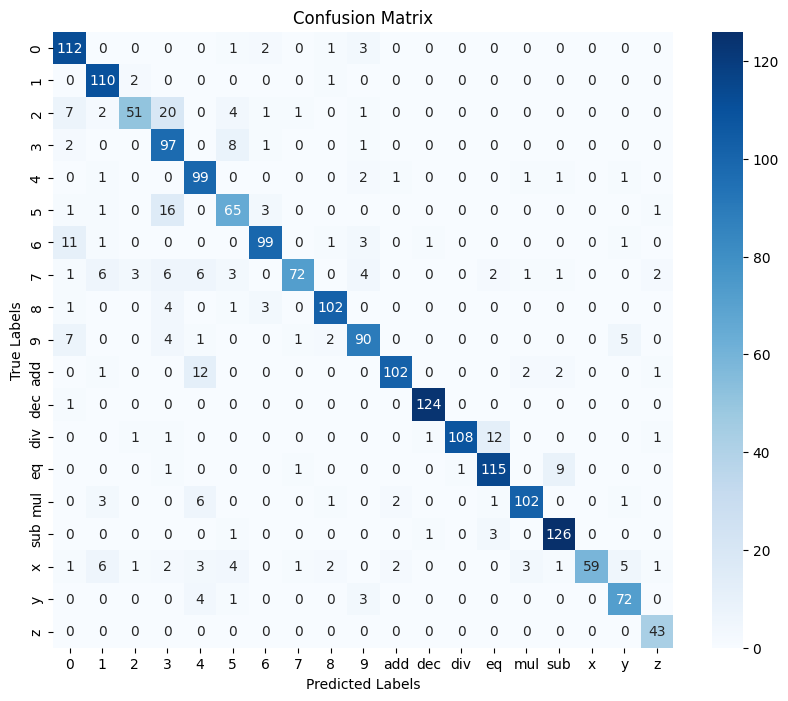

In [122]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=combined_classes,
            yticklabels=combined_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [81]:
report = classification_report(all_labels, all_preds, target_names=test_data.classes)
print(report)


              precision    recall  f1-score   support

           0       0.90      0.95      0.92       119
           1       1.00      0.85      0.92       113
           2       1.00      0.68      0.81        87
           3       0.87      0.89      0.88       109
           4       1.00      0.68      0.81       106
           5       0.95      0.82      0.88        87
           6       0.84      0.98      0.91       117
           7       0.82      0.93      0.87       107
           8       0.97      0.88      0.92       111
           9       0.86      0.97      0.91       110
         add       0.94      0.97      0.95       120
         dec       0.98      1.00      0.99       125
         div       0.99      0.98      0.99       124
          eq       0.98      0.96      0.97       127
         mul       1.00      0.91      0.95       116
         sub       0.96      1.00      0.98       131
           x       0.65      1.00      0.79        91
           y       0.97    

In [45]:
train_data.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'add',
 'dec',
 'div',
 'eq',
 'mul',
 'sub',
 'x',
 'y',
 'z']

In [87]:
def predict_from_url(model, url, transform, class_names, device=None):
    # Select device automatically if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Download the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Apply your transform (resize, normalize, etc.)
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Run inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        pred_class = class_names[pred.item()]

    print(f"Predicted class: {pred_class}")
    return pred_class

In [89]:
predict_from_url(model, test_url, resnet34_transformer, train_data.classes)

Predicted class: x


'x'

In [123]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [136]:
path = '/kaggle/working/test_number_samples/22661.jpg'

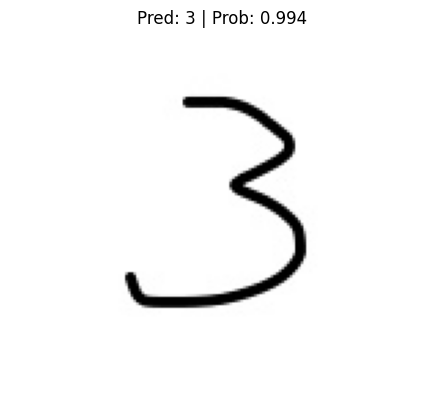

In [137]:
pred_and_plot_image(
                model=model, 
                image_path=path,
                class_names=train_data.classes,
                transform=resnet34_transformer
                )

In [139]:
torch.save(model.state_dict(), 'handrec_model_state.pth')